<a href="https://www.kaggle.com/code/soumyakushwaha/ethicalcommunicationai?scriptVersionId=137275279" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   #for data visualization and graphical plotting
from matplotlib import style      #for styling the plot
style.use("ggplot")

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import re
import string

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Importing the Dataset

In [3]:
data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Data Visualization

In [4]:
# to get more info about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


Adding  a new column to this dataset as labels which will contain the values as:

1. Hate Speech 
2. Offensive Language 
3. No Hate and Offensive

In [6]:
data["labels"] = data["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet                 labels  
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     Offensive Language  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     Offensive Language  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...     Offensive Language  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     Offensive Language  


In [7]:
# analysing some data
print(data["tweet"].iloc[0],"\n")
print(data["tweet"].iloc[1],"\n")
print(data["tweet"].iloc[2],"\n")
print(data["tweet"].iloc[3],"\n")
print(data["tweet"].iloc[4],"\n")

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!! 

!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit 

!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny 

!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361; 



Now we only select the tweet and labels columns for the rest of the task of training a hate speech detection model:

In [8]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


## Data Preprocessing

In [9]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [10]:
#applying pre-processing to text data
data.tweet=data['tweet'].apply(clean)

In [11]:
# removing duplicate data
tweetData = data.drop_duplicates("tweet")

In [12]:
# to see updated number of columns as duplicates entries are removed
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   labels  24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


In [13]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [14]:
#lemmatizing the processed data
tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))

/tmp/ipykernel_106/1037466657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))


In [15]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [16]:
# to see distribution of labels
tweetData['labels'].value_counts()

Offensive Language       18984
No Hate and Offensive     4113
Hate Speech               1409
Name: labels, dtype: int64

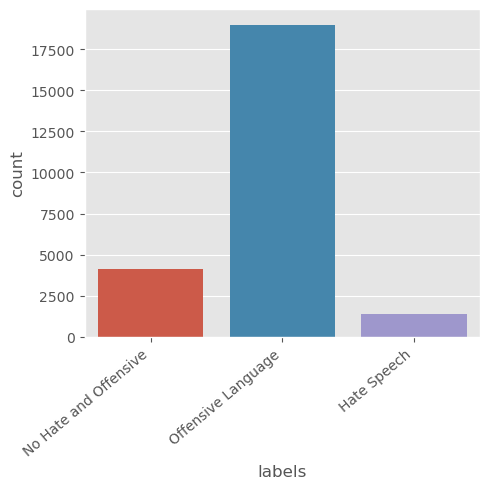

In [17]:
# to visualize the data using a count plot
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=tweetData)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

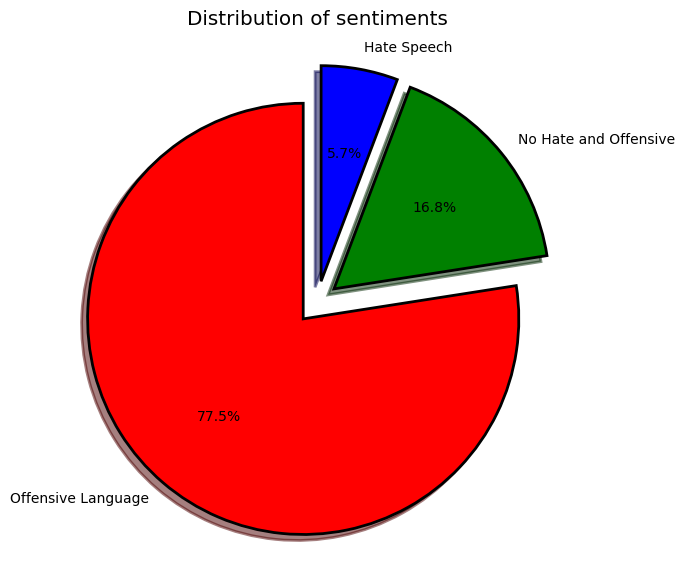

In [18]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = tweetData['labels'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

#here 0 indicates hate speech, 1 indicates offensive Language & 2 indicates no hate & offensive

In [19]:
# visualizing non-hate tweets
non_hate_tweets = tweetData[tweetData.labels=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,labels
0,rt mayasolovely woman shouldnt complain cleani...,No Hate and Offensive
40,momma said pussy cats inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,allaboutmanfeet woof woof hot soles,No Hate and Offensive
67,allyhaaaaa lemmie eat oreo amp dishes one oreo...,No Hate and Offensive


In [20]:
non_hate_tweets.value_counts()

tweet                                                                                                           labels               
                                                                                                                No Hate and Offensive    1
rt joleendoreen kik group called party line old charlie barber always hogging calls                             No Hate and Offensive    1
rt kickin trash cans golf cart yeeyee jbilinovich                                                               No Hate and Offensive    1
rt kickman giants pitiful jetspitiful mets pitiful yankeespitiful nets pitiful knickspitiful ny sports pitiful  No Hate and Offensive    1
rt kid listened nas showed new perspective coming ghetto like pimp c                                            No Hate and Offensive    1
                                                                                                                                        ..
jstarrtweets took harder rivera 

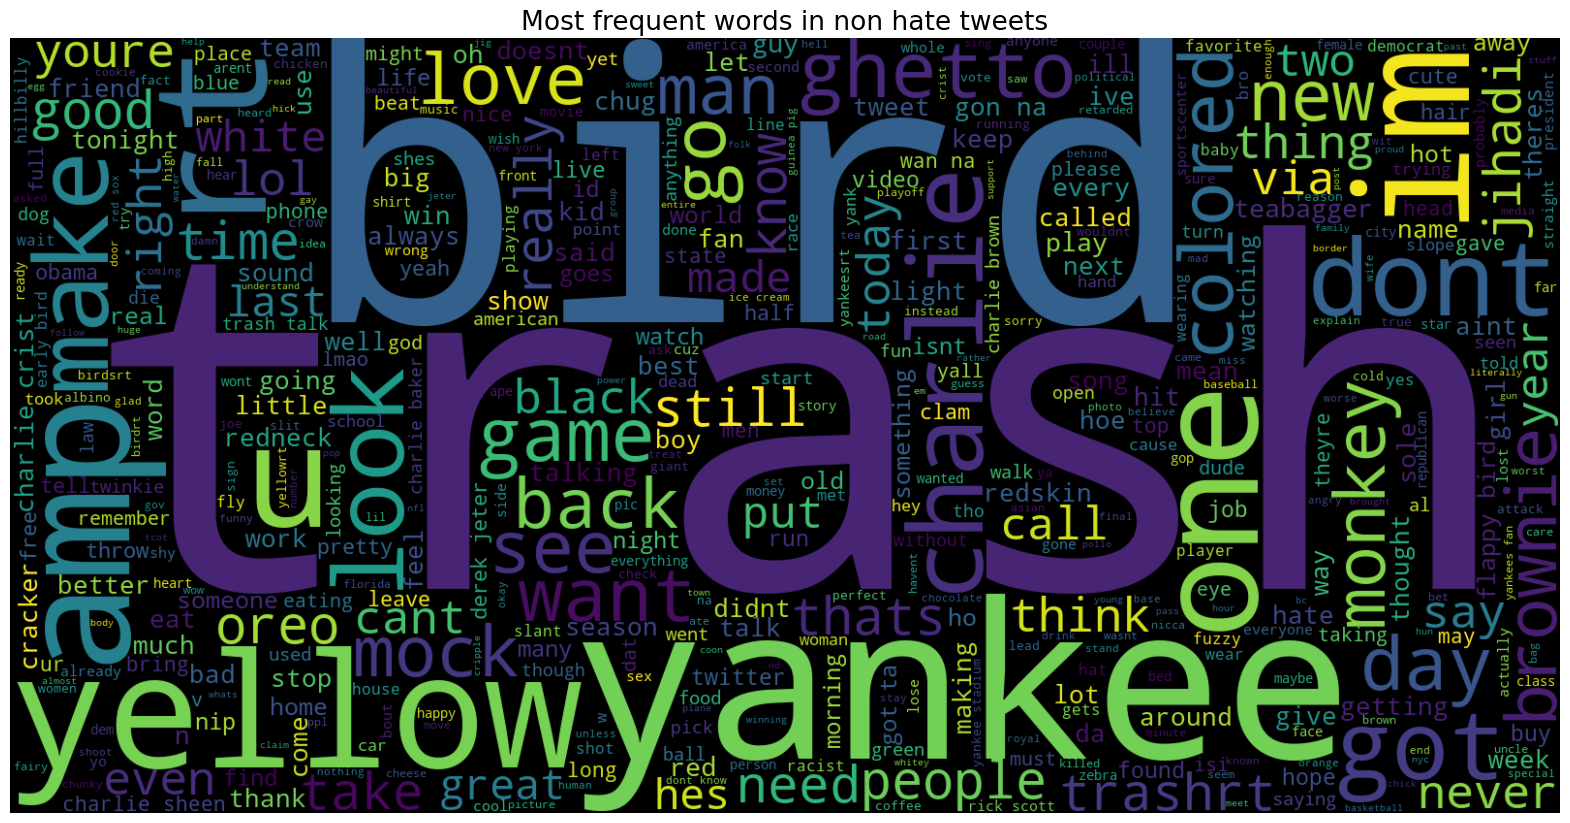

In [21]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

**TF - IDF: Term frequence - Inverse Document Frequency**

    TF-IDF = TF(t,d) x IDF(t),
    where TF(t,d) = number of times term "t" appears in a document "d".
          IDF(t) = inverse document frequency of the term t

The TF-IDF vectorizer converts a collection of raw documents into a matrix of TF-IDF features.

* **Bigram model**: provides probability of the next word given the past two words.
* **Trigram model**: provides probability of the next word based on past three words.
* **N-gram model**: provides probability based on past N-words.

### TF-IDF Bigram Model

In [22]:
#vectorizing the text data using TfidVectorizer and create a bigram lanuage model
vect=TfidfVectorizer(ngram_range=(1,2)).fit(tweetData['tweet'])

In [23]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 161774
First 200 features: 
 ['aa' 'aa classes' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begins' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aaliyah curving'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhlovee' 'aaliyahhlovee yu'
 'aamaadmiparty' 'aamaadmiparty mix' 'aampt' 'aampt ackin' 'aamu']


### TF-IDF Trigram Model

In [24]:
#creating a trigram language model
vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])

In [25]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 310426
First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt']


## Split Dataset

In [26]:
#separating the data into x and y to build the model
X = tweetData['tweet']
Y = tweetData['labels']
X = vect.transform(X) #transforming the x data

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (19604, 310426)
Size of Y_train (19604,)
Size of X_test (4902, 310426)
Size of Y_test (4902,)


## Model Training & Testing

### 1. Logistic Regression

In [29]:
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

In [30]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100)) #printing accuracy of the model

Test accuracy: 85.31%


In [31]:
#printing confusion matrix and classification report
print(confusion_matrix(Y_test, logreg_predict))
print("\n")
print(classification_report(Y_test, logreg_predict))

[[  12   10  261]
 [   0  403  405]
 [   3   41 3767]]


                       precision    recall  f1-score   support

          Hate Speech       0.80      0.04      0.08       283
No Hate and Offensive       0.89      0.50      0.64       808
   Offensive Language       0.85      0.99      0.91      3811

             accuracy                           0.85      4902
            macro avg       0.85      0.51      0.54      4902
         weighted avg       0.85      0.85      0.82      4902



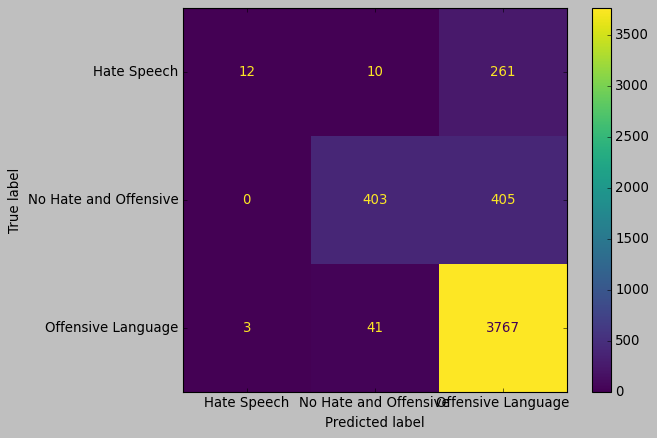

In [32]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

### Hyperparameter Tuning - GridSearchCV

In [33]:
#for performing hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [34]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, Y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.88
Best parameters:  {'C': 100, 'solver': 'lbfgs'}


In [35]:
log_grid_pred = grid.predict(X_test)

In [36]:
log_grid_acc = accuracy_score(log_grid_pred, Y_test)
print("Test accuracy: {:.2f}%".format(log_grid_acc*100)) #printing model accuracy after applying hyperparamenter tuning

Test accuracy: 89.29%


In [37]:
print(confusion_matrix(Y_test, log_grid_pred))
print("\n")
print(classification_report(Y_test, log_grid_pred))

[[  29   18  236]
 [   2  633  173]
 [  19   77 3715]]


                       precision    recall  f1-score   support

          Hate Speech       0.58      0.10      0.17       283
No Hate and Offensive       0.87      0.78      0.82       808
   Offensive Language       0.90      0.97      0.94      3811

             accuracy                           0.89      4902
            macro avg       0.78      0.62      0.64      4902
         weighted avg       0.88      0.89      0.87      4902



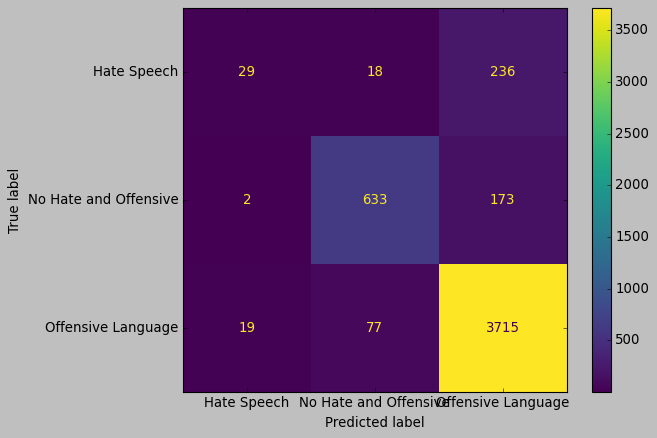

In [38]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, log_grid_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()

### 2. Decision Tree Classifier

In [39]:
#for training the data on decision tree classifier model
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train) #loading x_train and y_train data on model
dtree_predict = dtree.predict(X_test) #predicting the value for test data
dtree_acc = accuracy_score(dtree_predict, Y_test)

In [40]:
print("Test accuracy: {:.2f}%".format(dtree_acc*100)) #printing accuracy of the model

Test accuracy: 87.62%


In [41]:
#printing confusion matrix and classification report
print(confusion_matrix(Y_test, dtree_predict))
print("\n")
print(classification_report(Y_test, dtree_predict))

[[  58   34  191]
 [  20  681  107]
 [  94  161 3556]]


                       precision    recall  f1-score   support

          Hate Speech       0.34      0.20      0.25       283
No Hate and Offensive       0.78      0.84      0.81       808
   Offensive Language       0.92      0.93      0.93      3811

             accuracy                           0.88      4902
            macro avg       0.68      0.66      0.66      4902
         weighted avg       0.86      0.88      0.87      4902



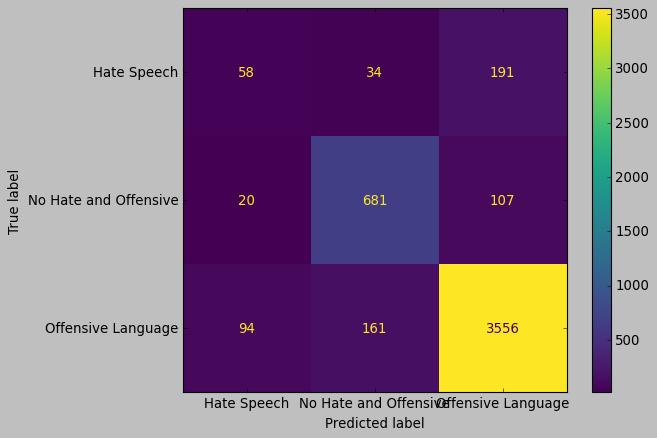

In [42]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, dtree_predict, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot()

## Model Deployment

def hate_speech_detection():
    import streamlit as st
    st.title("Hate Speech Detection")
    user = st.text_area("Enter any Tweet: ")
    if len(user) < 1:
        st.write("  ")
    else:
        sample = user
        data = cv.transform([sample]).toarray()
        a = clf.predict(data)
        st.title(a)
hate_speech_detection()